# Read Merged Gnews Data

Terry Szymanski  
16 May 2016  

I have created a csv file that merges all of the data from many crawls into a single dataset. This is easier to use in many ways, although it is not the most efficient / compact way of storing the data.

In this notebook I will illustrate loading this file and analyzing some properties of the data. This is mainly just to illustrate what the data looks like and how one might start doing an analysis based on it.

In [2]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import Levenshtein
from matplotlib import pyplot as plt
from lshash import LSHash

# This is the path to the file we will load. Change this as necessary.
csvfn = "merged.csv"

## Load the data into memory

In [3]:
%%time
# It takes about 30 seconds to load the file on my MacBook.
df = pd.read_csv(csvfn)

CPU times: user 15.8 s, sys: 2.53 s, total: 18.3 s
Wall time: 18.9 s


## Summary statistics

In [4]:
print ("Dataframe shape: {:}".format(repr(df.shape)))
print ("{:,} records (headline appearances)".format(df.shape[0]))
print ("{:} fields".format(df.shape[1]))
print ("{:,} unique headlines".format(len(set(df.title))))
print ("Date range: {:} to {:}".format(df.crawled_at.min()[:10], df.crawled_at.max()[:10]))

print ("\nNumber of records from different editions:")
print (df.edition.value_counts())

print ("\nNumber of records from different topics:")
print (df.topic.value_counts())

Dataframe shape: (2744491, 18)
2,744,491 records (headline appearances)
18 fields
1,218,080 unique headlines
Date range: 2015-10-19 to 2016-04-30

Number of records from different editions:
us       499718
uk       466266
in       462672
au       445804
ca       444743
en_ie    425288
dtype: int64

Number of records from different topics:
top    499267
s      256415
w      256274
n      254458
tc     252151
h      249056
e      248417
b      245466
m      244624
snc    238363
dtype: int64


# Description of record fields

Each record contains 18 distinct fields. There is a hierarchical structure in the data -- each row properly corresponds to a single **article**, but contains data relating to the **story** that contains that article, the **page** that contains that story, and the **crawl** that contains that page. Below I describe each field and illustrate some of the structure in the data.

### Fields that are unique to a crawl

The data was obtained by crawling multiple Google News pages, four times a day. Each time a crawl is performed, a unique crawl ID is generated.

* `crawl_id` -- a unique value assigned to each crawl, based on the timestamp when the crawl began.

### Fields that are unique to a page

Each **crawl** consists of fetching multiple **pages**. Each "page" is a page from the Google News website, identified by choosing a specific edition and topic. For example, `edition='en_ie'` and `topic='s'` identifies the Irish Sports page.

* `page_id` -- a unique ID for each page. This can be used to find all stories on a given page.
* `page_url` -- the URL of the specific Google News page that was crawled.
* `crawled_at` -- the time at which the page was crawled.
* `status` -- the HTTP status of the page request. This should always be 200 (anything else indicates an error in the crawl).
* `numstories` -- the total number of stories on the page (typically 10, but can vary).

### Fields that are unique to a story

Each **page** consists of a series of **stories**. Typically there are 10 stories per page, but the "Top Stories" page has more than 10. 

* `story_id` -- a unique ID for each story. This can be used to find all articles in a given story.
* `story_rank` -- the position where this story appeared on the page (typically a number between 0-9).
* `related` -- a list of "related" keywords for a story.
* `numarts` -- the nuber of articles in the given story (typically 3, but can vary).

### Fields that are unique for an article

Each **story** consists of a series of **articles**. Generally there are three articles associated with each story, but 

* `article_id` -- a unique ID for each article. This should uniquely identify a single row in the data.
* `article_rank` -- the position where this article appeared within the story (typically a number between 0-2). When this equals zero, that means that this is the lead article for the given story.
* `title` -- this is the headline itself.
* `snippet` -- a snippet (e.g. the first sentence) of the news article itself. This field only exists for the lead article in a story.
* `source` -- which newspaper published the headline.
* `edition` -- which edition was this record from (e.g. `us` = United States, `en_ie` = Ireland, etc.)
* `topic` -- which topic was this record from (e.g. `top` = Top Stories, `w` = World, `b` = Business, etc.)
* `url` -- the URL of the news article

### Note on field codes

The `edition` field uses the following codes:

* `us` - United States
* `uk` - United Kingdom
* `in` - India
* `au` - Australia
* `ca` - Canada
* `en_ie` - Ireland

The `topic` field uses the following codes:

* `top` - Top Stories
* `s` - Sports
* `w` - World
* `n` - Nation
* `tc` - Technology
* `h` - More Top Stories
* `e` - Entertainment
* `b` - Business
* `m` - Health
* `snc` - Science and Technology

Below is the first record from the data set, illustrating each of these fields:

In [5]:
df.iloc[0]

article_id                   3097f767-9f16-4fbe-aeff-080d9e9eb859
story_id                     dc0cae99-c2fe-4097-a9b6-afb91470fe6e
article_rank                                                    0
source                                                     CBC.ca
title           Canada's election campaign went off-script, wa...
snippet         It was a campaign that lasted so long it went ...
url             http://www.cbc.ca/news/politics/canada-electio...
page_id                      71e8de3e-4822-4e5e-b8bc-cd5bbe371178
story_rank                                                      0
numarts                                                         3
related                                       [u'Stephen Harper']
crawl_id                                             201510191739
crawled_at                             2015-10-19 17:39:41.742391
status                                                        200
edition                                                        ca
topic     

# Example: Finding all articles in a given story

It is easy to find all articles from a given story, once you know the `story_id` value that you are interested in.

In [6]:
MY_STORY_ID = df.iloc[0].story_id
df[df.story_id == MY_STORY_ID]

,article_id,story_id,article_rank,source,title,snippet,url,page_id,story_rank,numarts,related,crawl_id,crawled_at,status,edition,topic,numstories,page_url
0,3097f767-9f16-4fbe-aeff-080d9e9eb859,dc0cae99-c2fe-4097-a9b6-afb91470fe6e,0,CBC.ca,"Canada's election campaign went off-script, wa...",It was a campaign that lasted so long it went ...,http://www.cbc.ca/news/politics/canada-electio...,71e8de3e-4822-4e5e-b8bc-cd5bbe371178,0,3,[u'Stephen Harper'],201510191739,2015-10-19 17:39:41.742391,200,ca,top,38,http://news.google.com/news?ned=ca&authuser=0&...
1,a1e2667d-33c1-4e76-b76d-f33d90f5bb68,dc0cae99-c2fe-4097-a9b6-afb91470fe6e,1,Vancouver Sun,Polls open in BC for 2015 federal election,NaN,http://www.vancouversun.com/polls+open+2015+fe...,71e8de3e-4822-4e5e-b8bc-cd5bbe371178,0,3,[u'Stephen Harper'],201510191739,2015-10-19 17:39:41.742391,200,ca,top,38,http://news.google.com/news?ned=ca&authuser=0&...
2,f2c8e04c-0562-415d-af51-8b5fa5398a27,dc0cae99-c2fe-4097-a9b6-afb91470fe6e,2,rabble.ca (blog),"Where were the 'good Conservatives,' prepared ...",NaN,http://rabble.ca/blogs/bloggers/djclimenhaga/2...,71e8de3e-4822-4e5e-b8bc-cd5bbe371178,0,3,[u'Stephen Harper'],201510191739,2015-10-19 17:39:41.742391,200,ca,top,38,http://news.google.com/news?ned=ca&authuser=0&...


# Example: Finding all articles with a given keyword

Using the `related` keywords can be tricky -- because the values are a list, it does not always make sense to use strict equality to match. Also, many stories have emtpy `related` fields. In general, you should not rely on these to be accurate, but they can still be interesting.

In [7]:
MY_KEYWORD = "University College Dublin"
results = df[df.related.apply(lambda x: MY_KEYWORD in x)]
print(len(results), "articles contain keyword")
print (len(results.story_id.unique()), "unique stories contain keyword")
results.head(10)

156 articles contain keyword
57 unique stories contain keyword


,article_id,story_id,article_rank,source,title,snippet,url,page_id,story_rank,numarts,related,crawl_id,crawled_at,status,edition,topic,numstories,page_url
519597,75ccacba-0a99-4b7b-afb8-d792081c492e,58d04870-142a-4a2e-9447-f8b6a603b5a3,0,Irish Independent,Lowry inspires UCD to glory,EOIN LOWRY bagged 1-6 as UCD pulled away at Pa...,http://www.independent.ie/sport/gaelic-games/l...,40e67ced-b904-4411-8c4c-9b51622458f6,15,2,"[u'University College Dublin', u'Dublin City U...",201511260722,2015-11-26 07:22:26.083255,200,en_ie,s,20,http://news.google.com/news/section?topic=s&ne...
519598,0f4cd188-93ba-48a8-9cd2-a73259f20fef,58d04870-142a-4a2e-9447-f8b6a603b5a3,1,Irish Examiner,UCD finish strongly to claim Ryan Cup,NaN,http://www.irishexaminer.com/sport/gaa/footbal...,40e67ced-b904-4411-8c4c-9b51622458f6,15,2,"[u'University College Dublin', u'Dublin City U...",201511260722,2015-11-26 07:22:26.083255,200,en_ie,s,20,http://news.google.com/news/section?topic=s&ne...
580648,a8687edb-87da-4398-baf3-16a76e310ec3,3d59beea-04e7-4b14-8a6c-a40d7b0e0c60,0,JOE,GALLERY: UCD students get naked for charity ca...,"At this time of year, it's important to wrap u...",http://www.joe.ie/life-style/gallery-ucd-stude...,c5df45c3-d574-47a6-8f80-9ec45e6069b6,14,2,[u'University College Dublin'],201511301322,2015-11-30 13:22:31.369778,200,en_ie,m,20,http://news.google.com/news/section?topic=m&ne...
580649,3a42cc04-ea86-45d4-b9cc-5a1d1cc905e4,3d59beea-04e7-4b14-8a6c-a40d7b0e0c60,1,Yahoo News UK,Loads of UCD students have posed in the nip fo...,NaN,https://uk.news.yahoo.com/loads-ucd-students-p...,c5df45c3-d574-47a6-8f80-9ec45e6069b6,14,2,[u'University College Dublin'],201511301322,2015-11-30 13:22:31.369778,200,en_ie,m,20,http://news.google.com/news/section?topic=m&ne...
594918,576f1122-7a90-4c7a-af64-a52154d8faf7,71e8e184-e41f-4443-8270-f80688a20503,0,Irish Independent,UCD students strip off in aid of suicide preve...,A group of UCD students have stripped naked fo...,http://www.independent.ie/life/health-wellbein...,04d5d34f-4c51-4a0c-ba6b-b92434b1a00c,6,2,[u'University College Dublin'],201512011322,2015-12-01 13:22:35.602717,200,en_ie,m,20,http://news.google.com/news/section?topic=m&ne...
594919,48e141f2-4ebd-49cd-b4bd-46d0eb71bd78,71e8e184-e41f-4443-8270-f80688a20503,1,Mirror.co.uk,Naked students bare all for charity - and plan...,NaN,http://www.mirror.co.uk/news/uk-news/naked-stu...,04d5d34f-4c51-4a0c-ba6b-b92434b1a00c,6,2,[u'University College Dublin'],201512011322,2015-12-01 13:22:35.602717,200,en_ie,m,20,http://news.google.com/news/section?topic=m&ne...
1275761,5c941310-6e07-4e6e-a12f-761a14de75c2,e514d680-e3ae-4cc3-9a0d-904df2f6ac55,0,RTE.ie,VIDEO: New Student Jason Byrne aims for record...,Jason Byrne says he still has his eye on the L...,http://www.rte.ie/sport/soccer/2016/0118/76102...,48c6d5ab-5172-4f7f-938d-469b656d4041,8,2,"[u'Jason Byrne', u'University College Dublin A...",201601181922,2016-01-18 19:22:23.091763,200,en_ie,s,20,http://news.google.com/news/section?topic=s&ne...
1275762,83effb17-16c2-4575-80b6-9c28a62af3fd,e514d680-e3ae-4cc3-9a0d-904df2f6ac55,1,The42.ie,Student life for Jason Byrne as he closes in o...,NaN,http://www.the42.ie/jason-byrne-ucd-league-of-...,48c6d5ab-5172-4f7f-938d-469b656d4041,8,2,"[u'Jason Byrne', u'University College Dublin A...",201601181922,2016-01-18 19:22:23.091763,200,en_ie,s,20,http://news.google.com/news/section?topic=s&ne...
1300806,9c680248-a2c6-4d5d-8276-db946db2a67d,a1f5267f-1c6d-4daa-ac32-d43c85fb5cad,0,Irish Farmers Journal,Extra 5000 people milking cows by 2023 as UCD ...,The dairy industry in Ireland is set to receiv...,http://www.farmersjournal.ie/extra-5-000-peopl...,b4726522-e681-4543-b370-170b1d7f8f3e,9,3,[u'University College Dublin'],201601201322,2016-01-20 13:22:29.744083,200,en_ie,b,20,http://news.google.com/news/section?topic=b&ne...
1300807,609d87eb-c64a-4691-be30-785bf76a4fc7,a1f5267f-1c6d-4daa-ac32-d43c85fb5cad,1,Irish Examiner,UCD partners on €2.3m dairy research facility,NaN,http://www.

# Example: Finding the top sources in the UK

With `pandas` it is easy to manipulate the data frame and analyze subsets of the data. Here I group the data by source and get the total number of articles published by each source, limiting my analysis to only those articles that come from the `uk` edition.

In [8]:
MY_EDITION = "uk"
counts = df[df.edition==MY_EDITION].source.value_counts()
print ("{:,} articles from {:,} distinct sources.".format(counts.sum(), len(counts)))
print ("\nMost frequent sources:")
print (counts.head(10))
print ("\nLeast frequent sources:")
print (counts.tail(10))

466,266 articles from 8,127 distinct sources.

Most frequent sources:
Telegraph.co.uk      27141
The Guardian         25947
Daily Mail           24611
BBC News             18120
The Independent      11616
Reuters UK            9082
Financial Times       8905
Mirror.co.uk          8290
Belfast Telegraph     6509
Sky News              5188
Name: source, dtype: int64

Least frequent sources:
Scified                   1
KEYT                      1
Woodford Times            1
The Portugal News         1
decanter.com              1
The Transcontinental      1
Sport Diver               1
Nextgov                   1
Modern Tire Dealer        1
The Daily Princetonian    1
Name: source, dtype: int64


# Analysis: Variety of Sources

There are a huge number (tens of thousands) of news sources represented in the dataset. However, a fairly small number of these tend to dominate, meaning that a fairly small number of these sources account for a large percentage of all the articles that appear. Below I do a quick analysis of how many sources are needed to constitute a certain percentage of articles, analyzing each edition separately.

In [9]:
editions = df.edition.unique()
pcts = np.arange(0, 1, 0.1)+0.1 
variety = pd.DataFrame(index=pcts, columns=editions)

for edition in editions:
    ed = pd.DataFrame(df[df.edition==edition].source.value_counts())
    total = ed.source.sum()
    ed['cumpct'] = ed.source.cumsum() / total
#     print(ed)
    for pct in pcts:
        variety.loc[pct, edition] = len(ed[ed.cumpct < pct]) + 1
    print ("In edition '{:5s}', {:2d} sources comprise 50% of stories.".format(edition, variety.loc[0.5, edition]))
    print (ed.head(10))

variety

In edition 'ca   ', 33 sources comprise 50% of stories.
                    source    cumpct
CBC.ca               37309  0.083889
CTV News             32373  0.156679
The Globe and Mail   17976  0.197098
Toronto Sun          15973  0.233013
Toronto Star         13361  0.263055
Globalnews.ca         9937  0.285399
National Post         8972  0.305572
Vancouver Sun         7704  0.322894
Reuters Canada        7478  0.339709
Montreal Gazette      6756  0.354899
In edition 'en_ie', 13 sources comprise 50% of stories.
                     source    cumpct
Irish Independent     60160  0.141457
Irish Times           42574  0.241563
Irish Examiner        33685  0.320769
RTE.ie                25070  0.379717
Irish Mirror          12887  0.410019
Newstalk 106-108 fm    7194  0.426934
TV3.ie                 6563  0.442366
BreakingNews.ie        5903  0.456246
Daily Mail             5424  0.469000
thejournal.ie          4177  0.478821
In edition 'us   ', 52 sources comprise 50% of stories.
       

,ca,en_ie,us,au,uk,in
0.1,2,1,3,2,2,1
0.2,4,2,7,4,4,3
0.3,7,3,15,6,9,5
0.4,15,5,28,12,22,7
0.5,33,13,52,21,48,10
0.6,76,32,95,45,101,14
0.7,165,82,173,108,214,27
0.8,369,210,381,261,485,75
0.9,1027,694,1014,788,1209,240
1.0,8588,7415,8290,7571,8127,4846


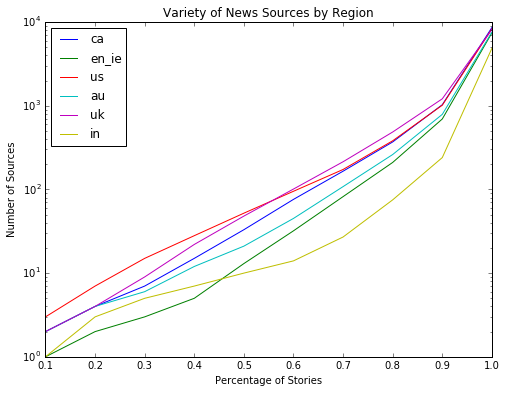

In [10]:
ax = variety.plot(logy=True, figsize=(8,6))
ax.set_title("Variety of News Sources by Region")
ax.set_ylabel("Number of Sources")
ax.set_xlabel("Percentage of Stories")
plt.show()

The plot above illustrates how much "variety" there is in the sources used in each region. It shows how many sources are need to comprise a certain percentage of the total records in the data. For example, at the very bottom left of the chart we can see that in India and Ireland, a single source comprises at least 10% of the total articles, while in Australia, the UK, and Canada, two sources are needed to reach 10%, and in the US three sources are needed. What this suggests is that the US spreads the stories among more different sources, whereas India and Ireland have a smaller number of sources that dominate most of the coverage.

It is also interesting to note that ultimately, all of the editions reach roughly the same number of sources overall; at 100%, the US, UK, Canada, Ireland, and Australia all contain approximately 8,000 sources (India is by far smaller, reaching approximately 5,000 total sources overall).

# To-Do #1: Link Stories

There are currently no explicit links between `stories`. However, we would like to have these links. A story which appears at 9AM in the Irish edition of Google News is probably still present at 5PM, and might even still be present the following day. Likewise, an international news story that appears in the Irish edition will probably also appear in the UK edition and the US edition, and so on. And a story in the "Sports" topic section might also appear in the "Top News" topic.

Generally, we are interested in linking stories under the following circumstances:

1. Link `stories` that appear in **different crawls** of the **same page**. 
2. Link `stories` that appear in **different topics** in the **same crawl**.
3. Link `stories` that appear in **different editions** in the **same crawl**.

The restrictions of being in the same page and same crawl could be lifted, and perhaps we just want to link all stories in all places. However, limiting our scope in some way can be useful to avoid over-linking stories. (For example, we don't want to link every single story that has "Dublin" as a related keyword.)

Determining whether or not two stories should be linked is not trivial. Typically this would be done with some kind of topic modeling or document similarity, but in our data we do not have access to the full text of the articles, only the headlines. We could do a textual similarity calculation over the headlines (and we may want to do this), but we also have the `url` and `related` fields to help us.

As a first approximation, we could try the following method for linking stories:

1. **Link any two stories that share a common `article` `url`.** I think that this approach will have perfect precision, but possibly low recall: any two stories that contain the exact same article, as identified by its URL, are certainly the same story, but because we only have 2 or 3 URLs per story, we will miss out on a lot of the URLs that we would like to use for this method.

2. **Link any two stories with the same `related` keywords, from the same `crawl` or from adjacent `crawls`**. This also seems like a fairly safe (i.e. low chance of false positives) approach. At a given point in time, it is unlikely that two different stories will have exactly the same set of `related` keywords. This is less restrictive than the URL approach, and it should capture most cases of a single story that is spread out over time, i.e. appears in multiple, successive `crawls`.

I think these two steps will result in a fair number of linked `stories` while minimizing the false positive error rate. However, it is certain to have missing links, so the false negative error rate may be substantial. Depending on how substantial it is, we might want to move on to other approaches to story linking.

Note that nearly every story in the "Top Stories" and "More Top Stories" topics will link to an identical story elsewhere in the same crawl. By design, the "Top Stories" page will always include 2-3 stories directly taken from the "true" topic pages, i.e. "Sports", "Business", "Technology", etc. In many ways, it makes sense to exclude these topics (`'top'` and `'h'`) because they are not really topics of their own, but aggegates of the other topics.

In [12]:
# Here is a naive, painfully slow way to do the first step. 
# This needs to be re-written to run in a much faster way, 
# but it illustrates the point.
links = []
story_ids = df.story_id.unique()
for i in range(len(story_ids)):
    for j in range(i, i+100):  # Limit to the 100 nearest stories, for time constraints.
        story1 = story_ids[i]
        story2 = story_ids[j]
        urls1 = df[df.story_id==story1].url
        urls2 = df[df.story_id==story2].url
        overlap = set(urls1).intersection(set(urls2))
        if overlap:
            print ("Linked!", i, j)
            links.append((story1, story2))
    if i >= 5: # Stop at 5 because otherwise this would take all day.
        break

Linked! 0 0
Linked! 1 1
Linked! 2 2
Linked! 2 61
Linked! 3 3
Linked! 4 4
Linked! 5 5


This identifies all the self-links, which is good (but not very useful), and correctly links one story which appeared in both the "Top Stories" topic (`top`) and the "Business" topic (`b`): 

In [ ]:
df[df.story_id == links[3][0]]

In [ ]:
df[df.story_id == links[3][1]]

In this section we will find different articles which may link to the same story by levenshtein distance of each article's headlines. In first step, we will choose a specific article and then find any other articles whose levenshtein distance smaller than a threshold.

In [82]:
def link_article(headline,start_pos,end_pos):
    links = []
    distance = []
    #     threshold = 0.5
    article_titles = df.title.unique()
    for row in article_titles[start_pos:end_pos]:
        distance.append(Levenshtein.distance(headline, row))

    levdis = pd.DataFrame(distance,columns = ["distance"])
    rank = levdis.sort("distance")
    links = rank.head(10)
    return links

In [87]:
article = df.title.unique()
print(df.iloc[1].title)

Polls open in BC for 2015 federal election


In [86]:
%%time
links = link_article(df.iloc[1].title,0,len(article))
for i in links.index:
    print(article[i])
print(links)

Polls open in BC for 2015 federal election
Polls open in Turkey's 26th general election
Polls open in General Election
Polls open in landmark Tanzania election
Polls open in Iran's parliamentary elections
Polls open for two Vic by-elections
Polls open in Central African Republic election
Polls open in Central African Republic elections
Polls Open in Iran's Parliamentary Elections
Polls open in seat Labor has never won
        distance
1              0
74856         13
801744        15
36078         18
799889        19
69011         19
440409        20
440211        21
800398        21
288118        21
CPU times: user 6.91 s, sys: 142 ms, total: 7.05 s
Wall time: 7.04 s


In [8]:
lsh = LSHash(6, 8)

In [9]:
lsh.index([1,2,3,4,5,6,7,8])

In [10]:
lsh.index([2,3,4,5,6,7,8,9])

In [11]:
lsh.index([10,12,99,1,5,31,2,3])

In [12]:
lsh.query([1,2,3,4,5,6,7,7])

[((1, 2, 3, 4, 5, 6, 7, 8), 1), ((2, 3, 4, 5, 6, 7, 8, 9), 11)]